# Immorthon

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [71]:
import pandas as pd

dicoName = "dico-mit.csv"
# dicoName = "dico-ef.csv"

# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
  !git clone https://github.com/sully-vian/immorthon.git
  dicoPath = "immorthon/" + dicoName
else:
  dicoPath = "./" + dicoName

# set pandas to print full strings
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(dicoPath, encoding="utf-8", on_bad_lines="error", na_filter=False)
df["text"] = "Define: " + df["word"] + "\n" + df["definition"]

# print line where word is none
(df[df["word"].isnull()])

# print line where word == "house"
print(df[df["word"] == "null"])

fatal: destination path 'immorthon' already exists and is not an empty directory.
      word             definition                                 text
5648  null  having the value zero  Define: null\nhaving the value zero


In [57]:
L = [
    ["word", "definition"],
    ["foo", "foo definition"],
    ["null", "null definition"],
    ["hehe", "hehe"]
]

df = pd.DataFrame(L[1:], columns=L[0])
df

,word,definition
0,foo,foo definition
1,null,null definition
2,hehe,hehe


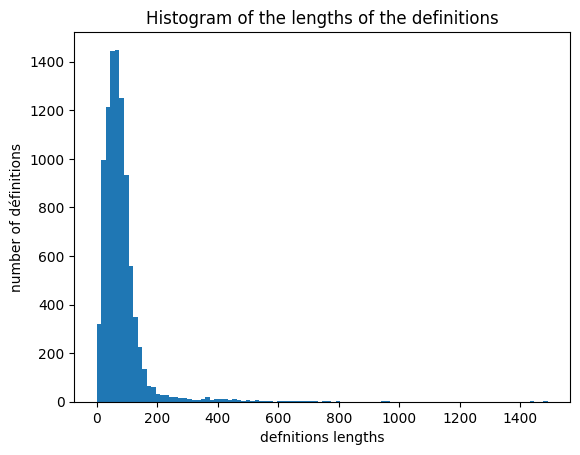

In [72]:
import matplotlib.pyplot as plt

definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

In [73]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["text"]])
# séparer aléatoirement la data en train et test
splitDataset = dataset.train_test_split(test_size=0.1)

In [74]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# par ordre croissant de taille
modelNames = [
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[0]
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(modelName)

def tokenize(examples):
    encoding = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=32
    )
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenizedDataset = splitDataset.map(tokenize, batched=True)

Map:   0%|          | 0/8394 [00:00<?, ? examples/s]

Map:   0%|          | 0/933 [00:00<?, ? examples/s]

In [75]:
from transformers import TrainingArguments, Trainer

trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-75-eb22fd972da1>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,3.654800
20,2.275600
30,2.161100
40,1.989500
50,1.709500
60,1.919300
70,1.914000
80,1.899400
90,1.801200
100,1.665900


TrainOutput(global_step=1050, training_loss=1.668807326725551, metrics={'train_runtime': 92.279, 'train_samples_per_second': 90.963, 'train_steps_per_second': 11.379, 'total_flos': 68541403889664.0, 'train_loss': 1.668807326725551, 'epoch': 1.0})

In [84]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = "Define: " + prompt
    results = generator(fullPrompt, max_length=64, num_return_sequences=numDef, do_sample=True, temperature=0.7)
    return [result["generated_text"] for result in results]

for result in generate("hexashoe", 3):
    print(result, end="\n\n")

Device set to use cuda:0


Define: hexashoe
a first name for girls

Define: hexashoe
a long-legged creature with a long tail and a long tail that is usually pointed down to the bottom when moving in a hard direction

Define: hexashoe
a small   in the US, with very large holes and a short hard shell.  is a first name for boys, but a first name is for girls

